<img src="http://www.ceic.org.ar/spanish/img/siisa-logo.jpg" align='right'>

# Análisis sobre el dataset de cobranzas de "Mi Adelanto".
### Estudio de la optimización en el protocolo de cobranzas.


##### Dataset:
La consulta sobre las tablas del banco Santander Rio y Banco de comercio como instrumentos de cobro a traves de cobro por CBU.

Comienzo el analisis con la tabla de santander a modo de analsis "historico" para luego centrarme en banco de comercio donde se realizo los ultimos debitos de los clientes vigentes.

In [76]:
# Importando las librerias necesarias para trabajar correctamente.

import pymssql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
hide_toggle()

In [56]:
#Rutina que esconde el codigo para mayor legibilidad.
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide Code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [3]:
# auxiliary functions.
def get_data_fsql(query,serverName='MiAdelanto'):
    """Traer data de las bases SQL
    query=String donde hago la query que quiero traer
    serverName= String(siisa/MiAdelanto)"""
    #Select Server 'MiAdelanto'
    if serverName=='MiAdelanto':
        #Name server.
        server='miadelanto.cw8tpboctrtb.us-west-2.rds.amazonaws.com'
        # user server.
        user='jesica'
        # Password.
        password='Jesisol123'
        # used Database.
        db='dtsMiAdelanto'
    #Select Server 'siisa'
    elif serverName=='siisa':
        #Name server.
        server='motorsiisa2.cn5dtopedl5u.us-east-1.rds.amazonaws.com'
        # user server.
        user='elias'
        # Password.
        password='123456'
        # used Database.
        db='sbrde'
    else:
        print("Base de datos seleccionada incorrecta:")
    # connector instance
    conn = pymssql.connect(server=server, user=user, password=password, database=db)
    # Selected Query.
    df = pd.read_sql(query, conn)
    # Close connection.
    conn.close()
    return df
hide_toggle()

Realizo la consulta sobre la base de datos de Rendiciones de cuotas de santander. Muestro el dataframe obtenido:

In [67]:
# Selected Query of santander's database.
query="""SELECT  a.*, b.*,d.* 
from dtsMiAdelanto.dbo.SantanderRioDebitosRendicionesCuotas a
LEFT JOIN dtsMiAdelanto.dbo.SantanderRioDebitosRendicionesCodigos  b ON a.Codigo = b.Codigo
LEFT JOIN dtsMiAdelanto.dbo.Prestamos  c ON c.PrestamoId = a.PrestamoId
LEFT JOIN dtsMiAdelanto.dbo.Clientes  d ON d.ClienteId = c.ClienteId"""
# Make dataframe from query.
df_cobros = get_data_fsql(query)
hide_toggle()

In [70]:
print("El tamaño de la matrix obtenida de la consulta es:",df_cobros.shape)
hide_toggle()

El tamaño de la matrix obtenida de la consulta es: (21259, 55)


In [63]:
df_cobros.head(3)

,RendicionId,PrestamoComercioId,PrestamoSucursalId,PrestamoId,CuotaId,ItemId,Importe,Fecha,Codigo,attrImputado,...,attrBlocked,attrAttempts,attrChangePassword,CreateUser,CreateDate,UpdateUser,UpdateDate,attrDeleted,fecha_debito,dia_debito
0,1,1,1,100108,1,1,1586.00,2016-08-08,000,True,...,True,NaN,None,web,2016-07-01 00:22:00,sergiorocha,2019-01-22 13:28:00,None,8,Monday
1,2,1,1,100058,3,1,1586.00,2016-08-08,000,True,...,True,3.0,None,import,2016-06-14 12:33:00,None,NaT,None,8,Monday
2,2,1,1,100061,3,1,2089.34,2016-08-08,000,True,...,None,NaN,None,import,2016-06-14 12:33:00,None,NaT,None,8,Monday


#### Día de Cobro reportado por el cliente.
La idea es ver la distribución historica del día de cobro informado por el cliente. 

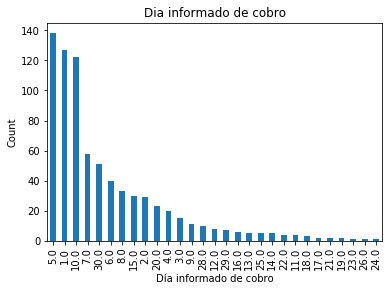

In [74]:
# Saco la redundancia hago un drop sobre los clientes.
df_cobros_drop_duplicates=df_cobros.drop_duplicates(subset='ClienteId',keep='last')
# grafico dia de cobro informado vs la cantidad de clientes que dicen cobrar en esa fecha.
g1=df_cobros_drop_duplicates.DiaCobro.dropna().value_counts().plot(kind='bar')

g1.set_xlabel("Día informado de cobro")
g1.set_ylabel("Count")
g1.set_title("Dia informado de cobro")
hide_toggle()

Sin embargo si vemos los prestamos y los clientes vigentes y comparamos los dias que informan siguen la siguiente distribucion:

In [109]:
query_base_clientes="""/* Consulta que debo realizar de modo de traer el dataframe. */
SELECT 
tprestamos.CreateDate,
tprestamos.PrestamoComercioId,
tprestamos.PrestamoId,
tprestamos.ClienteId,
tprestamos.PlanId,
tprestamos.Fecha,
tprestamos.FechaRetiro,
tprestamos.NroCuotas,
tprestamos.Capital,
tprestamos.Anticipo,
tclientes.Apellidos,
tclientes.Nombres,
tclientes.CUIL,
tclientes.Sexo,
tclientes.FechaNacimiento,
tclientes.Actividad,
tclientes.NacionalidadId,
tclientes.DiaCobro,
tclientes.CBU,
tbancos.BancoId,
tbancos.BancoNombre,
tprestamoestado.EstadoNombre
/* tabla principal */
from dtsMiAdelanto.dbo.Prestamos           as tprestamos
/* joineo con la tabla de clientes. */
LEFT JOIN dtsMiAdelanto.dbo.Clientes       as tclientes      ON tprestamos.ClienteId=tclientes.ClienteId
/* joineo con la tabla de bancos. */
LEFT JOIN dtsMiAdelanto.dbo.bancos as tbancos  ON tbancos.BancoId=    SUBSTRING(tclientes.CBU,1,3)
/* joineo con la tabla de prestamos Estados. */
LEFT JOIN dtsMiAdelanto.dbo.PrestamosEstados as tprestamoestado   ON tprestamoestado.EstadoId=tprestamos.EstadoId
"""

df_prestamos=get_data_fsql(query_base_clientes)
df_clientes_vigentes=df_prestamos[df_prestamos.EstadoNombre=='Vigente'].drop_duplicates(subset='ClienteId')
hide_toggle()

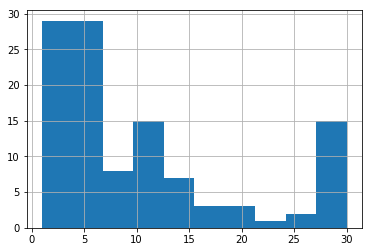

In [114]:
df_clientes_vigentes.DiaCobro.dropna().hist()
hide_toggle()

El dia reportado por la cartera de clientes esta concentrado principalmente en los primero 10 dias del mes como cabe de esperar. Por ende a continuación nos preguntamos si los dias en que se realizo efectivamente el  debito.



#### Fecha de realización del debito.

A continuación miramos tanto el dia de debito efectivo como la fecha en el que ocurrió. Observamos que los datos tambien señalan que el débito ocurre en los primeros dias del mes.

In [75]:
df_cobros['fecha_debito']=df_cobros.Fecha.dt.day
df_cobros['dia_debito']  =df_cobros.Fecha.dt.weekday_name
hide_toggle()

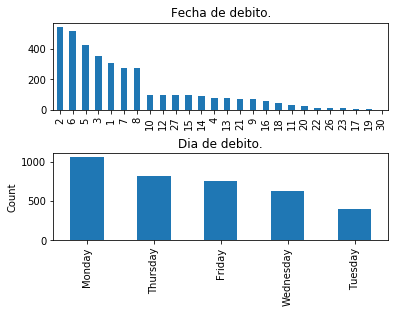

In [89]:
# no discrimino por Id de cliente. Veo el total de la transacciones.
fecha_debito_correcto=df_cobros[df_cobros.Descripcion=='Debito Correcto']


plt.subplots_adjust(hspace =0.5)
plt.subplot(2, 1, 1)
g1=fecha_debito_correcto.fecha_debito.dropna().value_counts().plot(kind='bar')
g1.set_title('Fecha de debito.')

plt.subplot(2, 1, 2)
g2=df_cobros.dia_debito.dropna()[df_cobros.Descripcion=='Debito Correcto'].value_counts().plot(kind='bar')
g2.set_ylabel('Count')
g2.set_title('Dia de debito.')
plt.show()

hide_toggle()

#### Correlación entre dia reportado y dia de debito efectivo.
Sin embargo si miramos si existe alguna correlación entre las variables, vemos que no existe correlacion directa. Por ende concluimos que la gente no informa con seguridad la fecha de cobro, sino que mas bien pone una fecha aproximada. 

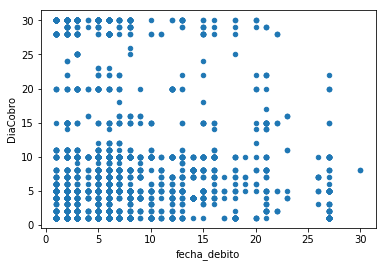

In [90]:
fecha_debito_correcto[['fecha_debito','DiaCobro']].dropna().plot.scatter(x='fecha_debito',y='DiaCobro')
hide_toggle()

#### Ejemplo de clientes que reportaron cobrar el dia 5 y la distribucion efectiva fecha de debito.

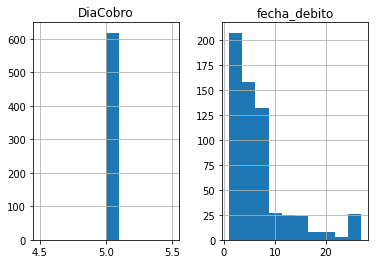

In [99]:
fecha_debito_correcto[['fecha_debito','DiaCobro']][fecha_debito_correcto.DiaCobro==5].hist()
hide_toggle()

<div class="alert alert-block alert-info">
<b>Resultado preliminar:</b> El dia de cobro no se corresponde generalmente con el dia en que ocurrio el debito. Sin emabargo si se observo que gran parte de la cartera de clientes informa que percibe su sueldo/haberes en los primeros 10 dias del mes.
</div>

In [12]:
fecha_debito_correcto[['DiaCobro','fecha_debito']].dropna().head(10)
hide_toggle()

In [13]:
fecha_debito_correcto[['DiaCobro','fecha_debito']].min(),fecha_debito_correcto[['DiaCobro','fecha_debito']].max()

(DiaCobro        1.0
 fecha_debito    1.0
 dtype: float64, DiaCobro        30.0
 fecha_debito    30.0
 dtype: float64)

### Que los que no se realizo el debito cual fue la razon?

In [14]:
# Dataframe donde el debito no se realizo apropiadamente.
fecha_debito_incorrecto=df_cobros[df_cobros.Descripcion!='Debito Correcto']

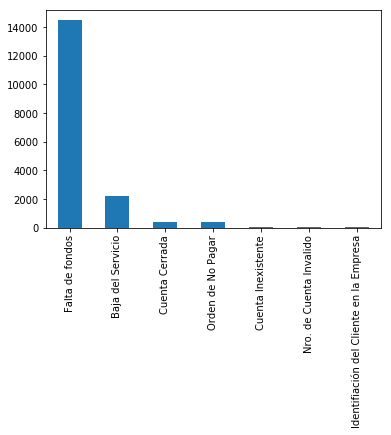

In [64]:
fecha_debito_incorrecto.Descripcion.value_counts().plot(kind='bar')
hide_toggle()

### A que dia la semana corresponde los eventos que no son debitos correctos??

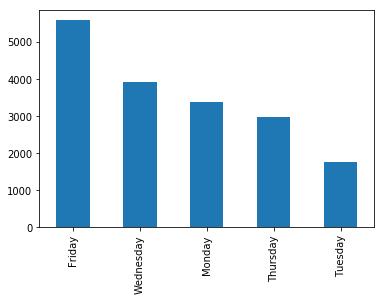

In [65]:
# Dia de la semana donde el debito se computo incorrectamente.
fecha_debito_incorrecto.dia_debito.dropna().value_counts().plot(kind='bar')
hide_toggle()


### Que fecha corresponde a los eventos que NO son debitos correctos?


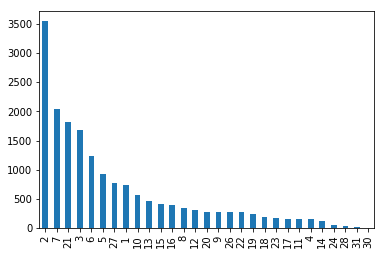

In [17]:
# Fecha donde se realizo el debito incorrectamente.
fecha_debito_incorrecto.fecha_debito.value_counts().plot(kind='bar')

### Sera no es el cuando sino el cuanto?

In [18]:
df_debito_sinfondos=df_cobros[(df_cobros.Descripcion == 'Debito Correcto') | (df_cobros.Descripcion == 'Falta de fondos')]

In [19]:
df_debito_sinfondos.head(3)


,RendicionId,PrestamoComercioId,PrestamoSucursalId,PrestamoId,CuotaId,ItemId,Importe,Fecha,Codigo,attrImputado,...,attrBlocked,attrAttempts,attrChangePassword,CreateUser,CreateDate,UpdateUser,UpdateDate,attrDeleted,fecha_debito,dia_debito
0,1,1,1,100108,1,1,1586.00,2016-08-08,000,True,...,True,NaN,None,web,2016-07-01 00:22:00,sergiorocha,2019-01-22 13:28:00,None,8,Monday
1,2,1,1,100058,3,1,1586.00,2016-08-08,000,True,...,True,3.0,None,import,2016-06-14 12:33:00,None,NaT,None,8,Monday
2,2,1,1,100061,3,1,2089.34,2016-08-08,000,True,...,None,NaN,None,import,2016-06-14 12:33:00,None,NaT,None,8,Monday


In [20]:
df_debito_sinfondos.shape

(18124, 57)

In [21]:
df_debito_sinfondos[['RendicionId','PrestamoId','CuotaId','ItemId','Importe','Descripcion','Fecha','fecha_debito','dia_debito']].head(10)

,RendicionId,PrestamoId,CuotaId,ItemId,Importe,Descripcion,Fecha,fecha_debito,dia_debito
0,1,100108,1,1,1586.00,Debito Correcto,2016-08-08,8,Monday
1,2,100058,3,1,1586.00,Debito Correcto,2016-08-08,8,Monday
2,2,100061,3,1,2089.34,Debito Correcto,2016-08-08,8,Monday
3,2,100062,3,1,2089.34,Debito Correcto,2016-08-08,8,Monday
4,2,100063,2,1,2316.00,Debito Correcto,2016-08-08,8,Monday
5,2,100066,1,1,1283.67,Debito Correcto,2016-08-08,8,Monday
6,2,100066,3,1,1082.66,Debito Correcto,2016-08-08,8,Monday
7,2,100067,1,1,1880.00,Falta de fondos,2016-08-08,8,Monday
8,2,100067,3,1,1586.00,Falta de fondos,2016-08-08,8,Monday
9,2,100069,1,1,4442.00,Falta de fondos,2016-08-08,8,Monday


In [22]:
df_debito_sinfondos[(df_debito_sinfondos.PrestamoId==101267) & (df_debito_sinfondos.RendicionId==138) ][['RendicionId','PrestamoId','CuotaId','ItemId','Importe','Descripcion','Fecha','fecha_debito','dia_debito']]

,RendicionId,PrestamoId,CuotaId,ItemId,Importe,Descripcion,Fecha,fecha_debito,dia_debito
10764,138,101267,1,7,76.0,Debito Correcto,2018-04-27,27,Friday


In [23]:
#df_debito_sinfondos['COUNTER'] =1       #initially, set that counter to 1.
group_data = df_debito_sinfondos.groupby(['RendicionId','PrestamoId','CuotaId','Descripcion'])['Importe'].sum()
group_data.head()

RendicionId  PrestamoId  CuotaId  Descripcion    
1            100108      1        Debito Correcto    1586.00
2            100058      3        Debito Correcto    1586.00
             100061      3        Debito Correcto    2089.34
             100062      3        Debito Correcto    2089.34
             100063      2        Debito Correcto    2316.00
Name: Importe, dtype: float64

In [24]:
group_data2=df_debito_sinfondos.groupby(['RendicionId','PrestamoId','CuotaId',])['Importe'].sum()

In [25]:
group_data2.to_csv('pagos_totales.csv',header=True)

In [26]:
group_data.to_csv('pagos_parciales.csv', header=True)

In [27]:
df_pagos_totales= pd.read_csv('pagos_totales.csv')
df_pagos_parciales=pd.read_csv('pagos_parciales.csv')

In [28]:
df_pagos_totales.head()

,RendicionId,PrestamoId,CuotaId,Importe
0,1,100108,1,1586.00
1,2,100058,3,1586.00
2,2,100061,3,2089.34
3,2,100062,3,2089.34
4,2,100063,2,2316.00


In [29]:
df_pagos_parciales.head()

,RendicionId,PrestamoId,CuotaId,Descripcion,Importe
0,1,100108,1,Debito Correcto,1586.00
1,2,100058,3,Debito Correcto,1586.00
2,2,100061,3,Debito Correcto,2089.34
3,2,100062,3,Debito Correcto,2089.34
4,2,100063,2,Debito Correcto,2316.00


In [30]:
new_df = pd.merge(df_pagos_parciales, df_pagos_totales,  how='left', left_on=['RendicionId','PrestamoId','CuotaId'], right_on = ['RendicionId','PrestamoId','CuotaId'])

In [31]:
new_df['porcetage_cuota']=new_df[['Importe_x']].div(new_df.Importe_y, axis=0)

In [32]:
new_df[(new_df.PrestamoId==101213) & (new_df.RendicionId==138) ]

,RendicionId,PrestamoId,CuotaId,Descripcion,Importe_x,Importe_y,porcetage_cuota
5171,138,101213,2,Debito Correcto,164.0,2164.0,0.075786
5172,138,101213,2,Falta de fondos,2000.0,2164.0,0.924214


In [33]:
new_df.porcetage_cuota[new_df.Descripcion=='Debito Correcto'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: porcetage_cuota, dtype: float64

In [34]:
new_df[(new_df.porcetage_cuota==1.00) & (new_df.Descripcion=='Debito Correcto')].shape

(1707, 7)

In [35]:
new_df[(new_df.porcetage_cuota!=1.00) & (new_df.Descripcion=='Debito Correcto')].shape

(212, 7)

In [36]:
new_df.shape

(7575, 7)

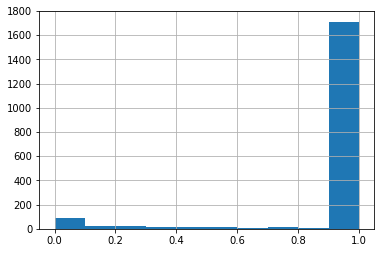

In [37]:
new_df.porcetage_cuota[new_df.Descripcion=='Debito Correcto'].hist(bins=10)

### Analizo para el Banco de Comercio.
Hago la consulta directamente sobre la tabla en cuestion. En en el periodo analizado no se realizaron impactos con el otro banco.

In [38]:
#Name server.
server='miadelanto.cw8tpboctrtb.us-west-2.rds.amazonaws.com'
# user server.
user='jesica'
# Password.
password='Jesisol123'
# used Database.
db='dtsMiAdelanto'
# connector instance
conn = pymssql.connect(server=server, user=user, password=password, database=db)
# Selected Query.
query="""select * from dtsMiAdelanto.dbo.BancoComercioDebitosRendicionesCuotas"""
# Make dataframe from query.
df_comercio = pd.read_sql(query, conn)
# Close connection.
conn.close()




In [39]:
df_comercio.head(3)

,RendicionId,PrestamoComercioId,PrestamoSucursalId,PrestamoId,CuotaId,ItemId,Importe,Fecha,Codigo,CodigoNombre,attrImputado
0,1,1,1,101851,0,1,0.0,2019-06-04,R,R10-Falta de fondos,False
1,1,1,1,101856,0,1,6384.0,2019-06-04,C,None,True
2,1,1,1,101861,0,1,2814.0,2019-06-04,C,None,True


Que dias se realizo el impacto??

In [40]:
df_comercio["date"] = df_comercio.Fecha.astype("datetime64")

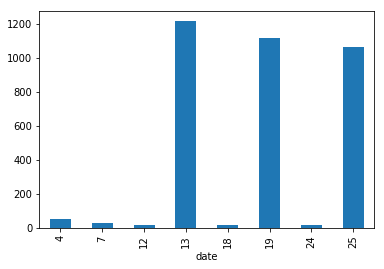

In [41]:
df_comercio.groupby(df_comercio["date"].dt.day)["date"].count().plot(kind="bar")

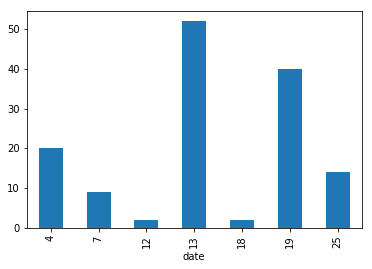

In [42]:
df_comercio[df_comercio.Codigo=="C"].groupby(df_comercio["date"].dt.day)["date"].count().plot(kind="bar")

Los casos donde no tengo el cobro cual fue la razon??

In [43]:
df_comercio.CodigoNombre.value_counts()

R10-Falta de fondos           2565
R02-Cuenta cerrada             548
R03-Cuenta inexistente         119
R08-Orden no pagar              87
R04-Nro de cuenta inv lido      50
R15-Baja del servicio           26
R93-D¡a no laborable            11
Name: CodigoNombre, dtype: int64

In [44]:
df_comercio.CodigoNombre.value_counts()[(df_comercio.CodigoNombre.value_counts().index!='R10-Falta de fondos') & (df_comercio.CodigoNombre.value_counts().index!='R93-D¡a no laborable') ].sum()

830

In [45]:
sinredundancia=df_comercio.drop_duplicates(subset=['PrestamoId'])
sinredundancia.CodigoNombre.value_counts()
#[(df_comercio.CodigoNombre.value_counts().index!='R10-Falta de fondos') & (df_comercio.CodigoNombre.value_counts().index!='R93-D¡a no laborable')]


R10-Falta de fondos           212
R02-Cuenta cerrada             40
R04-Nro de cuenta inv lido     13
R03-Cuenta inexistente         13
R15-Baja del servicio           6
R08-Orden no pagar              4
Name: CodigoNombre, dtype: int64

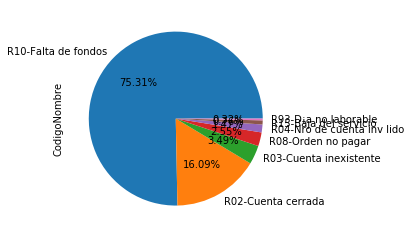

In [46]:
df_comercio.CodigoNombre.value_counts().plot(kind='pie',autopct='%.2f%%')

In [47]:
#df_comercio[df_comercio.CodigoNombre=='R10-Falta de fondos']
df_comercio[(df_comercio.CodigoNombre=='R02-Cuenta cerrada') | (df_comercio.CodigoNombre=='R03-Cuenta inexistente') |(df_comercio.CodigoNombre=='R08-Orden no pagar') | (df_comercio.CodigoNombre=='R04-Nro de cuenta inv lido')][['PrestamoId','CodigoNombre','Codigo','ItemId']].head()

,PrestamoId,CodigoNombre,Codigo,ItemId
24,101972,R03-Cuenta inexistente,R,1
70,101972,R03-Cuenta inexistente,R,1
92,101972,R03-Cuenta inexistente,R,1
114,100036,R02-Cuenta cerrada,R,1
115,100036,R02-Cuenta cerrada,R,2


 Cual es el porcentaje de Cobranzas?

In [48]:
df_comercio.Codigo.value_counts()/df_comercio.Codigo.value_counts().sum()


R    0.96079
C    0.03921
Name: Codigo, dtype: float64

In [49]:
df_comercio[df_comercio.Codigo=='C']

,RendicionId,PrestamoComercioId,PrestamoSucursalId,PrestamoId,CuotaId,ItemId,Importe,Fecha,Codigo,CodigoNombre,attrImputado,date
1,1,1,1,101856,0,1,6384.00,2019-06-04,C,None,True,2019-06-04
2,1,1,1,101861,0,1,2814.00,2019-06-04,C,None,True,2019-06-04
3,1,1,1,101882,0,1,6384.00,2019-06-04,C,None,True,2019-06-04
4,1,1,1,101893,0,1,4046.00,2019-06-04,C,None,True,2019-06-04
13,1,1,1,101930,0,1,5544.00,2019-06-04,C,None,True,2019-06-04
14,1,1,1,101938,0,1,2668.00,2019-06-04,C,None,True,2019-06-04
17,1,1,1,101944,0,1,1302.00,2019-06-04,C,None,True,2019-06-04
19,1,1,1,101946,0,1,6384.00,2019-06-04,C,None,True,2019-06-04
27,1,1,1,101982,0,1,2604.00,2019-06-04,C,None,True,2019-06-04
30,1,1,1,101992,0,1,4284.00,2019-06-04,C,None,True,2019-06-04


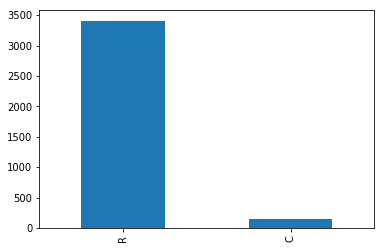

In [50]:
df_comercio.Codigo.value_counts().plot(kind='bar')

In [51]:
#Name server.
server='miadelanto.cw8tpboctrtb.us-west-2.rds.amazonaws.com'
# user server.
user='jesica'
# Password.
password='Jesisol123'
# used Database.
db='dtsMiAdelanto'
# connector instance
conn = pymssql.connect(server=server, user=user, password=password, database=db)
# Selected Query.
query="""SELECT a.PrestamoId, 
a.PlanId,
a.NroCuotas,
a.Capital,
a.Fecha,
b.ClienteId,
b.CUIL,
b.DiaCobro,
b.FechaNacimiento,
b.Sexo,
b.Actividad,
b.Apellidos,
b.Nombres,
d.EstadoNombre,
e.PlanNombre,
f.*,
g.*
FROM dtsMiAdelanto.dbo.Prestamos a 
LEFT JOIN dtsMiAdelanto.dbo.Clientes              b ON a.ClienteId = b.ClienteId 
LEFT JOIN dtsMiAdelanto.dbo.PrestamosEstados d on a.EstadoId=d.EstadoId 
LEFT JOIN dtsMiAdelanto.dbo.Planes e on e.PlanId=a.PlanId
LEFT JOIN dtsMiAdelanto.dbo.ClientesBancos f on b.clienteId = f.ClienteId
LEFT JOIN dtsMiAdelanto.dbo.Bancos g on f.BancoId=g.BancoId"""
# Make dataframe from query.
df_banco = pd.read_sql(query, conn)
# Close connection.
conn.close()

In [52]:
# A que banco pertenece cada usuario?
df_banco_clean=df_banco.drop_duplicates(subset='ClienteId',keep="last")
print(df_banco_clean.BancoNombre.value_counts().sum())
print(df_banco_clean.BancoNombre.value_counts())

276
BANCO DE LA NACION ARGENTINA                     40
BANCO SANTANDER RIO S.A.                         32
BANCO MACRO S.A.                                 27
BANCO DE GALICIA Y BUENOS AIRES S.A.             26
BANCO DE LA PROVINCIA DE BUENOS AIRES            21
BBVA BANCO FRANCES S.A.                          20
BANCO PATAGONIA  S.A.                            17
BANCO DE LA CIUDAD DE BUENOS AIRES               13
BANCO CREDICOOP COOPERATIVO LIMITADO             11
BANCO DE LA PROVINCIA DE CORDOBA S.A.(BANCOR)     9
NUEVO BANCO DE ENTRE RÍOS S.A.                    7
NUEVO BANCO DE SANTA FE SOCIEDAD ANONIMA          7
ICBC                                              6
NUEVO BANCO DEL CHACO S. A.                       5
HSBC BANK ARGENTINA S.A.                          5
BANCO DE SANTIAGO DEL ESTERO S.A.                 3
BANCO HIPOTECARIO S.A.                            3
BANCO SUPERVIELLE S.A.                            3
BANCO ITAU ARGENTINA S.A.                         2
BANCO DE

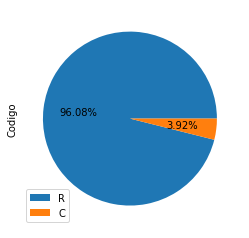

In [53]:
# Del total de la base de banco de comercio cual fue el exito de cobranza.
ax=df_comercio.Codigo.value_counts().plot(kind='pie',autopct='%.2f%%', labels=['','','',''],  fontsize=10)
#df[col].plot(kind='pie', autopct='%.2f', labels=['','','',''],  ax=ax, title=col, fontsize=10)
ax.legend(loc=3, labels=df_comercio.Codigo.value_counts().index)